In [1]:
# read in wrf auxout & lasso files
# compare large scale forcing

# perform area average on wrf 3-km outputs
# in order to match lasso 16-km outputs

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import pandas as pd
import wrf
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import xarray as xr
import datetime

# c1 site location
site_latitude  = 36.6050
site_longitude = -97.485

# interpolate wrf variables to this height
# also a specified height in lasso data
target_height_agl = 80

# omit number of cells on edges
cut_cells = 10

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd
plots_dir = nb_dir[0]+'/plots_04c'

# obs
co2flx25m_ncs = obs_dir+'sgpco2flx25mC1.b1/*.nc'
# obs bowen_ratio is nan...!

co2flx25m = xr.open_mfdataset(co2flx25m_ncs)

# plotting variables
co2flx25m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)']}

co2flx4m_ncs = obs_dir+'sgpco2flx4mC1.b1/*.nc'
co2flx4m = xr.open_mfdataset(co2flx4m_ncs)
co2flx4m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['latent_heat_flux', r'latent heat flux (W m$^{-2}$)']}

ebbre13_ncs = obs_dir+'sgp30ebbrE13.b1/*.nc'
ebbre13 = xr.open_mfdataset(ebbre13_ncs)
ebbre13_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['latent_heat_flux', r'latent heat flux (W m$^{-2}$)']}

ecore14_ncs = obs_dir+'sgp30ecorE14.b1/*.cdf'
ecore14 = xr.open_mfdataset(ecore14_ncs)
ecore14_dict = {'hfx': ['h', r'sensible heat flux (W m$^{-2}$)'], 
                'lh': ['lv_e', r'latent heat flux (W m$^{-2}$)']}

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

runs_list = list(data_dir_df.index)[:-1]

In [2]:
def plot_area_flux_ts(eval_date, run):

    dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'+data_dir_df[eval_date][run]+'/auxout/'

    df = pd.DataFrame()

    for file in glob.glob(dpath+'mmc_d04*'):

        if '_15:00' not in file: 

            wrf_single = Dataset(file, 'r')

            site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

            wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)

            hfx = wrf.getvar(wrf_single, 'HFX', timeidx=wrf.ALL_TIMES)
            lh = wrf.getvar(wrf_single, 'LH', timeidx=wrf.ALL_TIMES)

            if wrf_time.shape[0] > 1:

                hfx_1pt = hfx[:, site_loc_ij.values[1], site_loc_ij.values[0]]
                lh_1pt = lh[:, site_loc_ij.values[1], site_loc_ij.values[0]]

                hfx_cut = hfx[:, cut_cells:-cut_cells, cut_cells:-cut_cells]
                lh_cut = lh[:, cut_cells:-cut_cells, cut_cells:-cut_cells]

                hfx_mean = hfx_cut.mean(dim=['south_north', 'west_east'])
                hfx_std = hfx_cut.std(dim=['south_north', 'west_east'])

                lh_mean = lh_cut.mean(dim=['south_north', 'west_east'])
                lh_std = lh_cut.std(dim=['south_north', 'west_east'])

            else: 

                hfx_1pt = hfx[site_loc_ij.values[1], site_loc_ij.values[0]].values
                lh_1pt = lh[site_loc_ij.values[1], site_loc_ij.values[0]].values

                hfx_cut = hfx[cut_cells:-cut_cells, cut_cells:-cut_cells]
                lh_cut = lh[cut_cells:-cut_cells, cut_cells:-cut_cells]

                hfx_mean = hfx_cut.mean(dim=['south_north', 'west_east']).values
                hfx_std = hfx_cut.std(dim=['south_north', 'west_east']).values

                lh_mean = lh_cut.mean(dim=['south_north', 'west_east']).values
                lh_std = lh_cut.std(dim=['south_north', 'west_east']).values

            df_1file = pd.DataFrame(index=wrf_time, 
                                    data={'hfx_mean': hfx_mean, 'hfx_std': hfx_std, 'hfx_1pt': hfx_1pt, 
                                          'lh_mean': lh_mean, 'lh_std': lh_std, 'lh_1pt': lh_1pt})

            df = df.append(df_1file)

            df.sort_index(inplace=True)

    co2flx25m_ds = co2flx25m.sel(time=slice(df.index.min(), eval_date))
    co2flx4m_ds = co2flx4m.sel(time=slice(df.index.min(), eval_date))
    ebbre13_ds = ebbre13.sel(time=slice(df.index.min(), eval_date))
    ecore14_ds = ecore14.sel(time=slice(df.index.min(), eval_date))
            
    # resample wrf every 30 minute to match obs frequency
    # obs are 30-minute averages
    df = df.resample('30min').mean()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(df.index, df['hfx_mean'], label='wrf domain mean', c='k', linewidth=1.5)
    ax[0].plot(df.index, df['hfx_1pt'], label='wrf c1', c='k', linewidth=1, linestyle='--')
    ax[0].fill_between(df.index, df['hfx_mean']+df['hfx_std'], df['hfx_mean']-df['hfx_std'], color='k',
                       alpha=0.1, label='wrf mean + std')

    ax[1].plot(df.index, df['lh_mean'], label='wrf domain mean', c='k', linewidth=1.5)
    ax[1].plot(df.index, df['lh_1pt'], label='wrf c1', c='k', linewidth=1, linestyle='--')
    ax[1].fill_between(df.index, df['lh_mean']+df['lh_std'], df['lh_mean']-df['lh_std'], color='k',
                       alpha=0.1, label='wrf mean + std')

    # co2flx25m_ds

    for var, ax_i in zip(ebbre13_dict.items(), ax): 

        co2flx4m_ds[var[1][0]] = co2flx4m[var[1][0]].where(co2flx4m['qc_'+var[1][0]] <= 3)
        ax_i.plot(co2flx4m_ds['time'], co2flx4m_ds[var[1][0]], label='co2flx4m')

    for var, ax_i in zip(ebbre13_dict.items(), ax): 

        ebbre13_ds[var[1][0]] = ebbre13[var[1][0]].where(ebbre13['qc_'+var[1][0]] == 0)
        ax_i.plot(ebbre13_ds['time'], -ebbre13_ds[var[1][0]], label='ebbre13')

    for var, ax_i in zip(ecore14_dict.items(), ax): 

        ecore14_ds[var[1][0]] = ecore14[var[1][0]].where(ecore14['qc_'+var[1][0]] == 0)
        ax_i.plot(ecore14_ds['time'], ecore14_ds[var[1][0]], label='ecore14')

    for wrf_var, var in co2flx25m_dict.items(): 

        co2flx25m_ds[var[0]] = co2flx25m[var[0]].where(co2flx25m['qc_'+var[0]] <= 3)
        ax[0].plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')

    for var, ax_i in zip(co2flx4m_dict.items(), ax): 

        ax_i.set_title(var[1][0]+': '+run+'\n'+' vs obs: '+eval_date+'\nwrf mean std = '
                       +str(np.round(df[var[0]+'_std'].mean(), 3))+r' W m$^{-2}$')
        ax_i.set_ylabel(var[1][1])
    #     ax_i.axhline(color='grey', linestyle='--')
        ax_i.tick_params(labelrotation=90)

    #     ax_i.legend()
        handles, labels = ax_i.get_legend_handles_labels()
    #     print(labels)
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax_i.legend(handles, labels)

    ax[0].tick_params(labelrotation=90)
    ax[1].tick_params(labelrotation=90)
    
    plt.savefig(plots_dir+'/'+eval_date+'_2areaflux_'+run+'.pdf')

    plt.show()

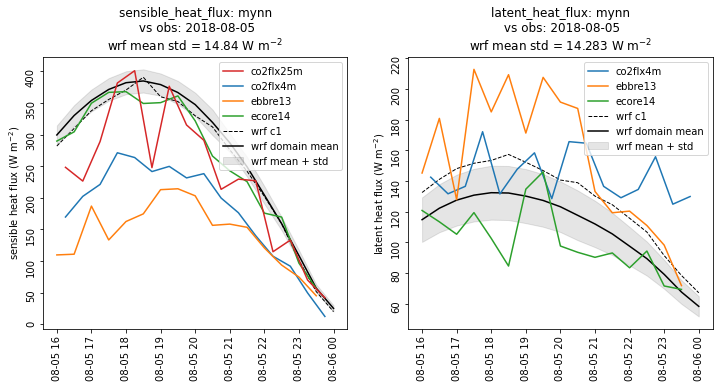

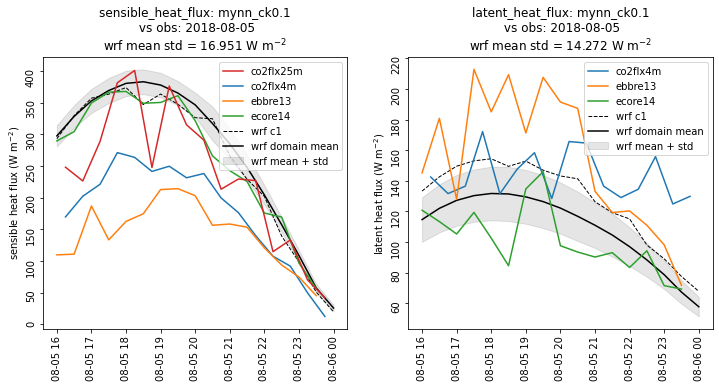

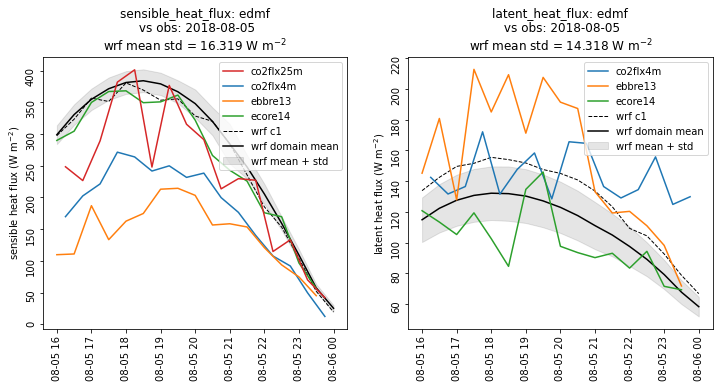

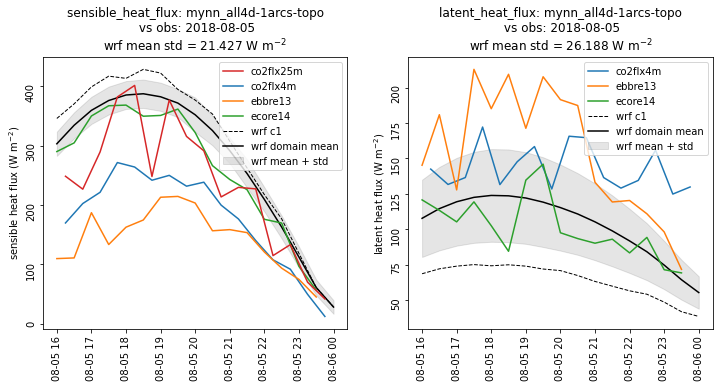

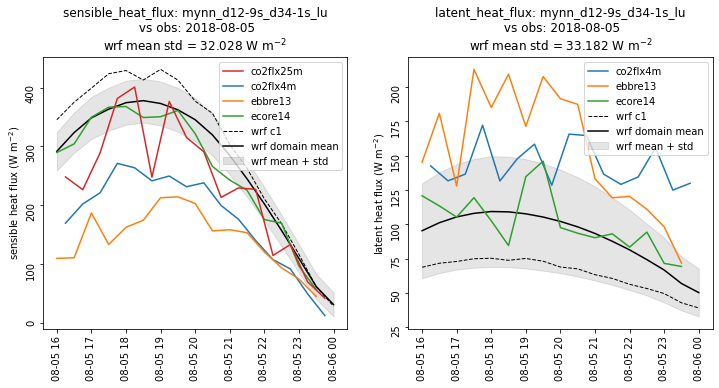

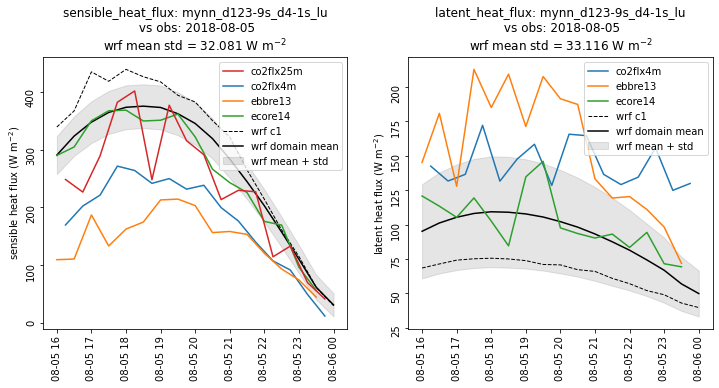

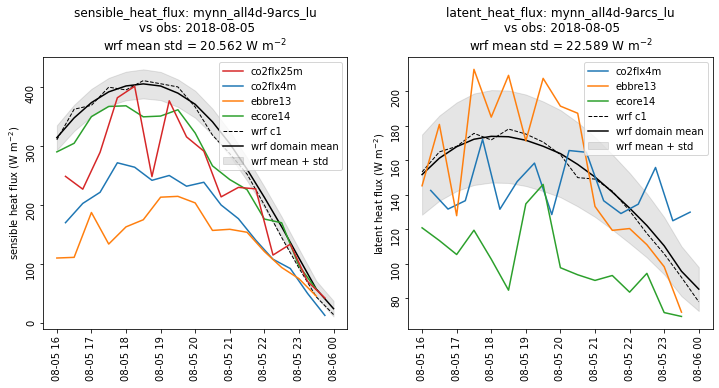

In [4]:
eval_date = '2018-08-05'

for run in runs_list: 
    plot_area_flux_ts(eval_date, run)

In [93]:
hfx_mean

<xarray.DataArray 'HFX' ()>
array(-3.2126684, dtype=float32)
Coordinates:
    XTIME    float32 2.16e+03
    Time     datetime64[ns] 2018-08-06

In [95]:
pd.DataFrame(index=wrf_time, data={'hfx_mean': hfx_mean.values})

,hfx_mean
2018-08-06,-3.212668


In [92]:
df_1file

,hfx_mean,hfx_std,hfx_1pt,lh_mean,lh_std,lh_1pt
2018-08-06,"<xarray.DataArray 'HFX' ()>\narray(-3.2126684,...","<xarray.DataArray 'HFX' ()>\narray(42.221954, ...","<xarray.DataArray 'HFX' ()>\narray(18.117317, ...","<xarray.DataArray 'LH' ()>\narray(96.41406, dt...","<xarray.DataArray 'LH' ()>\narray(49.86127, dt...","<xarray.DataArray 'LH' ()>\narray(63.869427, d..."


In [81]:
df_1file

,hfx_mean,hfx_std,hfx_1pt,lh_mean,lh_std,lh_1pt
2018-08-05 13:00:00,29.605160,22.549570,44.749924,43.471588,28.826183,30.410643
2018-08-05 13:10:00,44.461697,25.527706,62.171974,52.768864,31.974773,36.570839
2018-08-05 13:20:00,54.735039,28.111589,74.688362,60.397194,34.786995,41.509506
2018-08-05 13:30:00,65.421143,30.709684,87.408165,68.031631,37.745651,46.506176
2018-08-05 13:40:00,81.683609,33.922443,106.000969,77.547310,41.651836,52.736633
2018-08-05 13:50:00,92.809105,36.480629,119.025345,85.106354,44.904896,57.656109


In [75]:
df_1file

,hfx_mean,hfx_std,hfx_1pt,lh_mean,lh_std,lh_1pt
2018-08-05 12:00:00,-107.152649,81.830406,-115.687202,-103.330444,74.051262,-169.062881
2018-08-05 12:10:00,-13.580511,14.940534,-9.156095,11.320505,20.652605,8.248775
2018-08-05 12:20:00,-7.735733,15.406914,-2.185236,16.031279,21.458372,11.921228
2018-08-05 12:30:00,-0.743209,16.330603,6.809655,21.559875,22.626118,15.795577
2018-08-05 12:40:00,11.392712,18.272127,22.147596,29.574924,24.592218,20.914946
2018-08-05 12:50:00,20.186766,20.283964,33.286301,36.370480,26.595016,25.491013


In [55]:
hfx_mean.values

array([-107.15265   ,  -13.580511  ,   -7.735733  ,   -0.74320906,
         11.392712  ,   20.186766  ], dtype=float32)

In [53]:
df_1file

,hfx_mean,hfx_std,hfx_1pt,lh_mean,lh_std,lh_1pt
2018-08-05 12:00:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:10:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:20:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:30:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:40:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:50:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."


In [43]:
hfx

<xarray.DataArray 'HFX' (Time: 6, south_north: 220, west_east: 220)>
array([[[-106.04029   , -163.18684   , -152.90123   , ...,
          -60.473877  ,  -22.071964  ,  -91.76922   ],
        [-200.57564   , -198.27393   , -128.31491   , ...,
          -96.801674  ,  -84.1741    ,  -59.748707  ],
        [ -23.426624  ,  -25.348475  ,  -82.936714  , ...,
           28.927538  ,   27.18364   ,   23.000048  ],
        ...,
        [  -7.2628775 ,   -6.547519  ,   -9.93518   , ...,
         -166.30638   , -167.3442    , -170.3107    ],
        [ -13.470241  ,  -13.006612  ,  -14.51221   , ...,
         -157.77443   , -157.72644   , -167.01617   ],
        [ -10.1385145 ,   -9.394758  ,  -13.34052   , ...,
         -151.88626   , -154.11229   , -162.59242   ]],

       [[ -26.2471    ,  -28.444418  ,  -27.602818  , ...,
            3.5651646 ,    5.157714  ,    2.9707248 ],
        [ -30.037354  ,  -29.679583  ,  -26.187607  , ...,
            4.302999  ,    3.5784342 ,    3.311123  ],
        [ -23.449041  ,  -22.190624  ,  -26.698338  , ...,
           30.103199  ,   28.229908  ,   24.266655  ],
...
        [  -5.400262  ,   -3.6577508 ,   -5.87337   , ...,
            4.8296547 ,    6.0468884 ,   -8.295286  ],
        [  -8.874367  ,   -4.5495434 ,   -4.9376297 , ...,
            4.1329966 ,    5.6311545 ,  -12.506898  ],
        [  -9.819414  ,   -5.3304067 ,   -5.257641  , ...,
          -10.304967  ,  -15.478426  ,   -1.3154575 ]],

       [[  11.991716  ,    8.506018  ,    7.7092123 , ...,
           36.12912   ,   54.27799   ,   41.85117   ],
        [  10.890051  ,   10.0207    ,    9.2864    , ...,
           40.7095    ,   42.634758  ,   40.80424   ],
        [  12.513491  ,   11.422107  ,   10.62537   , ...,
           27.257555  ,   25.204227  ,   20.176516  ],
        ...,
        [  -4.932387  ,   -1.5615102 ,   -3.5427444 , ...,
            9.576076  ,   11.189602  ,   -7.97468   ],
        [  -7.3934555 ,   -3.5831957 ,   -4.3048663 , ...,
            8.7944765 ,   11.514689  ,    1.4626578 ],
        [ -11.101909  ,   -7.3469377 ,   -7.2819333 , ...,
            6.416996  ,   -1.9274702 ,    8.206313  ]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.4 -101.3 ... -94.12 -94.08
    XLAT     (south_north, west_east) float32 33.18 33.18 33.18 ... 39.11 39.11
    XTIME    (Time) float32 1.44e+03 1.45e+03 1.46e+03 ... 1.48e+03 1.49e+03
  * Time     (Time) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-05T12:50:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [19]:
hfx_1pt

<xarray.DataArray 'HFX' (Time: 6)>
array([-115.6872   ,   -9.156095 ,   -2.1852362,    6.809655 ,
         22.147596 ,   33.2863   ], dtype=float32)
Coordinates:
    XLONG    float32 -97.49
    XLAT     float32 36.59
    XTIME    (Time) float32 1.44e+03 1.45e+03 1.46e+03 ... 1.48e+03 1.49e+03
  * Time     (Time) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-05T12:50:00
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [7]:
def get_wrf_area_avg_tend(dpath):

    df = pd.DataFrame(columns=wrf_columns)

    for file in glob.glob(dpath+'mmc_d02*')[:1]:

        wrf_single = Dataset(file,'r')

        site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

        wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)
        
        hfx = wrf.getvar(wrf_single, 'HFX', timeidx=wrf.ALL_TIMES)
        lh = wrf.getvar(wrf_single, 'LH', timeidx=wrf.ALL_TIMES)
        
#         hgt = z_agl[:, site_loc_ij.values[1], site_loc_ij.values[0]]

        df_1file = pd.DataFrame(index=wrf_time, columns=wrfdf_columns)
        
    return df_1file

#         for t_ind, t in enumerate(wrf_time): 

#             hfx_list, lh_list = [], []

#             for i in range(int(area_start_ind[0]), int(area_end_ind[0]+1)):
#                 for j in range(int(area_start_ind[1]), int(area_end_ind[1]+1)): 
                    
#                     if wrf_time.shape[0] > 1: 
#                         t_tend_1pt = t_tend[t_ind, :, i, j]
#                         u_tend_1pt = u_tend[t_ind, :, i, j]
#                         v_tend_1pt = v_tend[t_ind, :, i, j]
#                     # for wrfout files that contain 1 time
#                     # e.g. the last out file of a run
#                     else: 
#                         t_tend_1pt = t_tend[:, i, j]
#                         u_tend_1pt = u_tend[:, i, j]
#                         v_tend_1pt = v_tend[:, i, j]
                    
#                     z_agl_1pt = z_agl[:, i, j]

#                     # tried wrf.vinterp(), can't get it working
#                     t_tend_itp = wrf.interp1d(t_tend_1pt, z_agl_1pt, levels)
#                     u_tend_itp = wrf.interp1d(u_tend_1pt, z_agl_1pt, levels)
#                     v_tend_itp = wrf.interp1d(v_tend_1pt, z_agl_1pt, levels)

#                     t_tend_list.append(t_tend_itp.values[0])
#                     u_tend_list.append(u_tend_itp.values[0])
#                     v_tend_list.append(v_tend_itp.values[0])

#             df_1file.loc[t, [meta_df['t']['wrf']]] = np.mean(t_tend_list)
#             df_1file.loc[t, [meta_df['u']['wrf']]] = np.mean(u_tend_list)
#             df_1file.loc[t, [meta_df['v']['wrf']]] = np.mean(v_tend_list)

#         df = df.append(df_1file)

#     df.sort_index(inplace=True)
    
#     return df

In [8]:
wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/l1_0805m/auxout/target/'

wrf_df = get_wrf_area_avg_tend(wrf_path)

In [9]:
wrf_df

,hfx,lh
2018-08-05 12:00:00,NaN,NaN
2018-08-05 12:10:00,NaN,NaN
2018-08-05 12:20:00,NaN,NaN
2018-08-05 12:30:00,NaN,NaN
2018-08-05 12:40:00,NaN,NaN
2018-08-05 12:50:00,NaN,NaN
